In [10]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import os
from matplotlib import pyplot as plt
from sklearn.neighbors import KNeighborsRegressor
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.layers import Input, Dense, Activation, Dropout
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import mean_squared_error
import re
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.models import Model

from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
import transformers

In [11]:
train_data = pd.read_csv('../input/commonlitreadabilityprize/train.csv')
test_data = pd.read_csv('../input/commonlitreadabilityprize/test.csv')

# removing unused columns
train_data.drop(['url_legal', 'license','standard_error'], axis=1, inplace=True)
test_data.drop(['url_legal', 'license'], axis=1, inplace=True)

from sklearn.model_selection import train_test_split
X=train_data['excerpt']
y=train_data['target']
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.15,random_state=20)
x_train, x_cv, y_train, y_cv = train_test_split(x_train, y_train, test_size=0.15,random_state=20)
x_td=test_data['excerpt']

In [12]:
MAX_LENGTH = 225
LR = 0.000040
AUTO = tf.data.experimental.AUTOTUNE
lr= 2e-5
wd=0.01

In [13]:
from transformers import RobertaConfig, RobertaTokenizer, TFRobertaModel
tokenizer = RobertaTokenizer.from_pretrained('../input/tfroberta-base')
# RoBerta Model:
#config = RobertaConfig(attention_probs_dropout_prob=0.2)
RoBerta = TFRobertaModel.from_pretrained('../input/tfroberta-base')

All model checkpoint layers were used when initializing TFRobertaModel.

All the layers of TFRobertaModel were initialized from the model checkpoint at ../input/tfroberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


In [14]:
def batch_encode(tokenizer, texts, batch_size=256, max_length=MAX_LENGTH):
    input_ids = []
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]
        inputs = tokenizer.batch_encode_plus(batch,max_length=max_length,padding='longest',truncation=True)
        input_ids.extend(inputs['input_ids'])
    return tf.convert_to_tensor(input_ids)

In [15]:
x_td_ids = batch_encode(tokenizer, x_td.tolist())

In [19]:
def build_model(transformer, max_length=MAX_LENGTH):
    input_ids_layer = tf.keras.layers.Input(shape=(max_length,),name='input_ids',dtype='int32')
    last_hidden_state = transformer(input_ids_layer)[0]
    cls_token = last_hidden_state[:, 0, :]
    output = tf.keras.layers.Dense(1,activation='linear',dtype = 'float32',kernel_initializer=tf.keras.initializers.GlorotNormal(seed=42))(cls_token)
    model = tf.keras.Model(input_ids_layer, output)
    model.compile(tf.keras.optimizers.Adam(lr = LR),  loss=tf.keras.losses.MeanSquaredError(),metrics=[tf.keras.metrics.RootMeanSquaredError()])
    return model

In [20]:
model_load=build_model(RoBerta,225)

In [21]:
no_models=5
models_list=[]
for i in range(no_models):
    model_load.load_weights('../input/roberta-models/reberta_model'+str(i)+'.h5')
    models_list.append(model_load)
    

In [22]:
def train_models_1():
    import numpy as np
    import random
    from sklearn.model_selection import KFold
    from tensorflow.keras import backend as K
    models_list=[]
    fold=0
    seed=123
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    tf.random.set_seed(seed)
    kf=KFold(n_splits=5, random_state=seed, shuffle=True)

    for train_index, test_index in kf.split(X):
        K.clear_session()
        fold=fold+1
        print('fold:',fold)
        x_train, x_cv = X[train_index], X[test_index]
        y_train, y_cv = y[train_index], y[test_index] 
        x_train_ids = batch_encode(tokenizer, x_train.tolist())
        x_cv_ids = batch_encode(tokenizer, x_cv.tolist()) 

        model=build_model(RoBerta,225)
        EPOCHS = 50
        BATCH_SIZE = 24
        NUM_STEPS = len(x_train.index) // (BATCH_SIZE*4)

        # Train the model
        from keras.callbacks import EarlyStopping
        early_stop_1=EarlyStopping(monitor='val_root_mean_squared_error',patience=5,restore_best_weights=True,mode='min')
        checkpoint = tf.keras.callbacks.ModelCheckpoint('./Roberta_Base_'+str(fold)+'.h5', 
                                                monitor = 'val_root_mean_squared_error', 
                                                verbose = 2, 
                                                save_best_only = True,
                                                save_weights_only = True, 
                                                mode = 'min')
        model.fit(
        x = x_train_ids,
        y = y_train,
        epochs = EPOCHS,
        batch_size = BATCH_SIZE,
        steps_per_epoch = NUM_STEPS,
        validation_data = (x_cv_ids, y_cv),
        verbose=1,callbacks=[early_stop_1]
        )
        models_list.append(model)
    for i in range(len(models_list)):
        models_list[i].save_weights('./reberta_model'+str(i)+'.h5')
    return models_list


In [23]:
#models_list=train_models_1()

In [25]:
y_pred=np.zeros((x_td_ids.shape[0],1))
for i in range(len(models_list)):
  y_pred=y_pred+models_list[i].predict(x_td_ids)
y_pred=y_pred/len(models_list)
y_pred

array([[-0.05351723],
       [-0.28107777],
       [ 0.02735828],
       [-2.41026878],
       [-1.98931468],
       [-0.87454116],
       [ 0.5268482 ]])

In [26]:
#%cd /kaggle/working
#from IPython.display import FileLink
#FileLink('./reberta_models4.h5')

#Predicting Test data

In [27]:
test_dat = pd.read_csv('../input/commonlitreadabilityprize/test.csv',index_col='id')
y_pred_pd=pd.DataFrame(y_pred,index=test_dat.index,columns=['target'])
#y_pred_pd=y_pred_pd.reset_index()
#saving test data predicted
y_pred_pd.to_csv('./submission.csv')
y_pred_pd

,target
id,
c0f722661,-0.053517
f0953f0a5,-0.281078
0df072751,0.027358
04caf4e0c,-2.410269
0e63f8bea,-1.989315
12537fe78,-0.874541
965e592c0,0.526848


#LeaderBoard

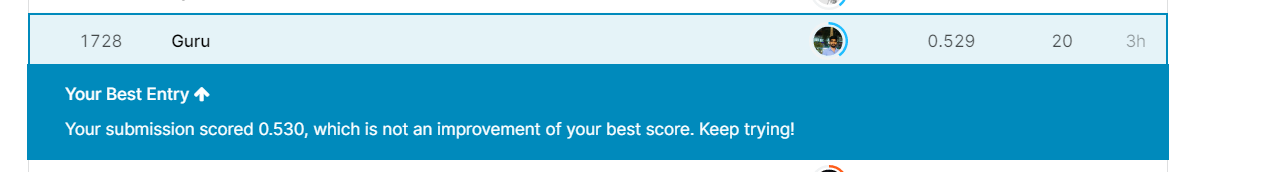
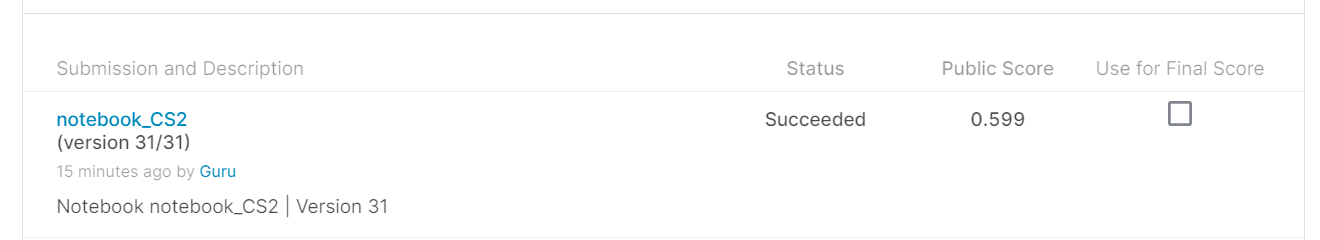